# MLF project : O2o coupon usage forecast

In [48]:
import os, sys, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import  auc, roc_curve

In [49]:
df_train = pd.read_csv('ccf_offline_stage1_train.csv') 
df_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')
df_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


In [50]:
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:05:00,1.0,20160712
1,6949378,1300,3429,30:05:00,NaN,20160706
2,2166529,7113,6928,200:20:00,5.0,20160727
3,2166529,7113,1808,100:10:00,5.0,20160727
4,6172162,7605,6500,30:01:00,2.0,20160708


# 1. data process

In [51]:
df_train=df_train.fillna('null')
df_test=df_test.fillna('null')
df_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,2.01602e+07
1,1439408,4663,11002,150:20,1,2.01605e+07,null
2,1439408,2632,8591,20:1,0,2.01602e+07,null
3,1439408,2632,1078,20:1,0,2.01603e+07,null
4,1439408,2632,8591,20:1,0,2.01606e+07,null


In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   User_id        int64 
 1   Merchant_id    int64 
 2   Coupon_id      object
 3   Discount_rate  object
 4   Distance       object
 5   Date_received  object
 6   Date           object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [53]:
print('The number of people with coupon and consumption: ',df_train[(df_train['Date_received'] != 'null') & (df_train['Date'] != 'null')].shape[0])
print('The number of people with coupon and without consumption: ',df_train[(df_train['Date_received'] != 'null') & (df_train['Date'] == 'null')].shape[0])
print('The number of people without coupon and with consumption: ',df_train[(df_train['Date_received'] == 'null') & (df_train['Date'] != 'null')].shape[0])
print('The number of people without coupon and without consumption: ',df_train[(df_train['Date_received'] == 'null') & (df_train['Date'] == 'null')].shape[0])

The number of people with coupon and consumption:  75382
The number of people with coupon and without consumption:  977900
The number of people without coupon and with consumption:  701602
The number of people without coupon and without consumption:  0


So we need to give coupon to those with consumption and without coupon. The amount of these people is 701602.

# 2. Label preparation

(1) Date_received == 'null' means the person did not receive a coupon, we don't need to consider it,so y = -1.

(2) (Date_received != 'null') & (Date != 'null') & (Date - Date_received <= 15) means the person received the coupon and used it within 15 days, which is our positive sample,so y = 1.

(3) (Date_received != 'null') & ((Date == 'null') | (Date - Date_received > 15)) means the person received the coupon but didn't use it within 15 days, which is our negative sample, so y = 0.

In [54]:
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        date_buy = pd.to_datetime(row['Date'],format='%Y%m%d')
        date_receive = pd.to_datetime(row['Date_received'],format='%Y%m%d')
        td =  date_buy - date_receive
        if td.days <= 15:
            return 1
    return 0

df_train['label'] = df_train.apply(label,axis=1)
df_train['label'].value_counts()

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64

We have 988887 negative samples and 64395 positive samples.

# 3. Featureextraction

  3.1 Discount rate

  There are three types of discount rate, which need to be broken down into new features.

In [55]:
df_train.Discount_rate.unique()
#whether the discount rate is null
def getDiscountType(row):
    if 'null' in row:
        return 0
    elif ':' in row:
        return 1
    else:
        return 2

#actual discount rate
def convertRate(row):
    if 'null' in row:
        return 1
    elif ':' in row:
        money = row.split(':')
        rate = 1.0 - float(money[1])/float(money[0])
        return rate
    else:
        return float(row)
    
#the threshold of discount
def getDiscount_threshold(row):
    if ':' in row:
        money = row.split(':')
        return int(money[0])
    elif 'null' in row:
        return 'null'
    else:
        return 0
    
#the discount amount
def getDiscount_minus(row):
    if ':' in row:
        money = row.split(':')
        return int(money[1])
    elif 'null' in row:
        return 'null'
    else:
        return 0


In [56]:
#apply 4 functions
def processData(df):
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_threshold'] = df['Discount_rate'].apply(getDiscount_threshold)
    df['discount_minus'] = df['Discount_rate'].apply(getDiscount_minus)
    print('discount rate %s' %df['discount_rate'].unique()) #actual discount rate
    return df

In [57]:
df_train = processData(df_train)
df_test = processData(df_test)
df_train.head()

discount rate [1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
discount rate [0.83333333 0.9        0.96666667 0.8        0.95       0.75
 0.98       0.5        0.86666667 0.6        0.66666667 0.7
 0.85       0.33333333 0.94       0.93333333 0.975      0.99      ]


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_rate,discount_threshold,discount_minus
0,1439408,2632,null,null,0,null,2.01602e+07,-1,0,1.000000,null,null
1,1439408,4663,11002,150:20,1,2.01605e+07,null,0,1,0.866667,150,20
2,1439408,2632,8591,20:1,0,2.01602e+07,null,0,1,0.950000,20,1
3,1439408,2632,1078,20:1,0,2.01603e+07,null,0,1,0.950000,20,1
4,1439408,2632,8591,20:1,0,2.01606e+07,null,0,1,0.950000,20,1


3.2 Distance

In [58]:
print(df_train['Distance'].unique())

#convert null into -1
df_train['distance'] = df_train['Distance'].replace('null',-1).astype(int)
df_test['distance'] = df_test['Distance'].replace('null',-1).astype(int)
df_train['distance'] .unique()

[0.0 1.0 'null' 2.0 10.0 4.0 7.0 9.0 3.0 5.0 6.0 8.0]


array([ 0,  1, -1,  2, 10,  4,  7,  9,  3,  5,  6,  8])

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   User_id             int64  
 1   Merchant_id         int64  
 2   Coupon_id           object 
 3   Discount_rate       object 
 4   Distance            object 
 5   Date_received       object 
 6   Date                object 
 7   label               int64  
 8   discount_type       int64  
 9   discount_rate       float64
 10  discount_threshold  object 
 11  discount_minus      object 
 12  distance            int32  
dtypes: float64(1), int32(1), int64(4), object(7)
memory usage: 167.4+ MB


2.3 The date of receiving the coupon

In [60]:
# range of date of receiving the coupon
date_receive = df_train['Date_received'].unique()
date_receive = sorted(date_receive[date_receive != 'null'])
print('The date of receiving the coupon：%d - %d'%(date_receive[0],date_receive[-1]))

The date of receiving the coupon：20160101 - 20160615


In [61]:
#range of date of purchase
date_buy = df_train['Date'].unique()
date_buy = sorted(date_buy[date_buy != 'null'])
print('The date of purchase：%d - %d'%(date_buy[0],date_buy[-1]))

The date of purchase：20160101 - 20160630


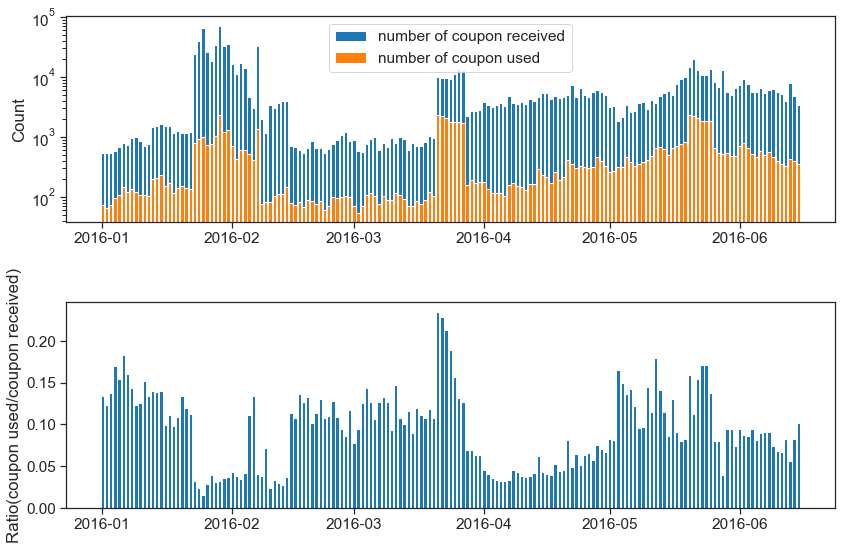

In [62]:
couponbydate = df_train[df_train['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
couponbydate.columns = ['Date_received','count']
buybydate = df_train[(df_train['Date'] != 'null') & (df_train['Date_received'] != 'null')][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
buybydate.columns = ['Date_received','count']

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style('ticks')
sns.set_context("notebook", font_scale= 1.4)
plt.figure(figsize = (12,8))
date_received_dt = pd.to_datetime(date_receive, format='%Y%m%d')

plt.subplot(211)
plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )
plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used')
plt.yscale('log')
plt.ylabel('Count')
plt.legend()

plt.subplot(212)
plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])
plt.ylabel('Ratio(coupon used/coupon received)')
plt.tight_layout()

In [63]:
#construct the feature of 'weekday'
def getWeekday(row):
    if row == 'null':
        return row
    else:
        weekday = date(int(row[0:4]),int(row[4:6]),int(row[6:8])).weekday() + 1
        return weekday
df_train['weekday'] = df_train['Date_received'].astype(str).apply(getWeekday)
df_test['weekday'] = df_test['Date_received'].astype(str).apply(getWeekday)
print(df_train['weekday'].unique())

['null' 6 3 1 5 4 7 2]


In [64]:
#construct the feature of 'weekday_type'
df_train['weekday_type'] = df_train['weekday'].apply(lambda x: 1 if x in [6,7] else 0)
df_test['weekday_type'] = df_test['weekday'].apply(lambda x: 1 if x in [6,7] else 0)
df_train['weekday_type'] .unique()

array([0, 1], dtype=int64)

If the date is weekday, weekday_type=0. If the date is weekend, weekday_type=1.

In [65]:
##construct the feature of 'weekday_number'

#training data
#one-hot-encoding
data = df_train['weekday'].replace('null',np.nan)
tmpdf = pd.get_dummies(data,prefix='weekday')
df_train = pd.concat([df_train,tmpdf],axis=1)

#test data
#one-hot-encoding
data = df_test['weekday'].replace('null',np.nan)
tmpdf = pd.get_dummies(data,prefix='weekday')
df_test = pd.concat([df_test,tmpdf],axis=1)

We got 7 dummy variables representing each day of a week.

In [66]:
df_train['User_id'].value_counts()

5054119    264
2751537    155
2949273    137
6655171    136
4840568    134
          ... 
5656800      1
3561697      1
1446120      1
1452271      1
8196         1
Name: User_id, Length: 539438, dtype: int64

In [67]:
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_type,discount_rate,discount_threshold,discount_minus,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,4129537,450,9983,30:05:00,1,20160712,1,0.833333,30,5,1,2,0,0,1,0,0,0,0,0
1,6949378,1300,3429,30:05:00,null,20160706,1,0.833333,30,5,-1,3,0,0,0,1,0,0,0,0
2,2166529,7113,6928,200:20:00,5,20160727,1,0.900000,200,20,5,3,0,0,0,1,0,0,0,0
3,2166529,7113,1808,100:10:00,5,20160727,1,0.900000,100,10,5,3,0,0,0,1,0,0,0,0
4,6172162,7605,6500,30:01:00,2,20160708,1,0.966667,30,1,2,5,0,0,0,0,0,1,0,0


In [68]:
df_train['Date_received'] = df_train['Date_received'].astype(str)
df_train['Date'] = df_train['Date'].astype(str)
df_train['Date_received'].unique()

array(['null', '20160528.0', '20160217.0', '20160319.0', '20160613.0',
       '20160516.0', '20160429.0', '20160129.0', '20160530.0',
       '20160519.0', '20160606.0', '20160207.0', '20160421.0',
       '20160130.0', '20160412.0', '20160518.0', '20160327.0',
       '20160127.0', '20160215.0', '20160524.0', '20160523.0',
       '20160515.0', '20160521.0', '20160114.0', '20160321.0',
       '20160426.0', '20160409.0', '20160326.0', '20160322.0',
       '20160131.0', '20160125.0', '20160602.0', '20160128.0',
       '20160605.0', '20160607.0', '20160324.0', '20160601.0',
       '20160126.0', '20160124.0', '20160123.0', '20160201.0',
       '20160522.0', '20160203.0', '20160417.0', '20160415.0',
       '20160202.0', '20160206.0', '20160218.0', '20160611.0',
       '20160329.0', '20160510.0', '20160302.0', '20160526.0',
       '20160318.0', '20160205.0', '20160411.0', '20160520.0',
       '20160527.0', '20160317.0', '20160213.0', '20160505.0',
       '20160402.0', '20160211.0', '20160405.0'

In [69]:
def userFeature(df):
    u = df[['User_id']].copy().drop_duplicates()
    
    # u_coupon_count : num of coupon received by user
    u1 = df[df['Date_received'] != 'null'][['User_id']].copy()
    u1['u_coupon_count'] = 1
    u1 = u1.groupby(['User_id'], as_index = False).count()

    # u_buy_count : times of user buy offline (with or without coupon)
    u2 = df[df['Date'] != 'null'][['User_id']].copy()
    u2['u_buy_count'] = 1
    u2 = u2.groupby(['User_id'], as_index = False).count()

    # u_buy_with_coupon : times of user buy offline (with coupon)
    u3 = df[((df['Date'] != 'null') & (df['Date_received'] != 'null'))][['User_id']].copy()
    u3['u_buy_with_coupon'] = 1
    u3 = u3.groupby(['User_id'], as_index = False).count()

    # u_merchant_count : num of merchant user bought from
    u4 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    u4.drop_duplicates(inplace = True)
    u4 = u4.groupby(['User_id'], as_index = False).count()
    u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)

    # min,max,mean and median diatance of purchase with coupon
    utmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['User_id', 'distance']].copy()
    utmp.replace(-1, np.nan, inplace = True)
    u5 = utmp.groupby(['User_id'], as_index = False).min()
    u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
    u6 = utmp.groupby(['User_id'], as_index = False).max()
    u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
    u7 = utmp.groupby(['User_id'], as_index = False).mean()
    u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
    u8 = utmp.groupby(['User_id'], as_index = False).median()
    u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)

    #merge all the features on User_id
    user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')
    
    # calculate rate
    #每个用户的优惠券使用率
    user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
    #每个用户线下消费中用券的比例
    user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
    user_feature = user_feature.fillna(0)
    
    print(user_feature.columns.tolist())
    return user_feature


In [70]:
def merchantFeature(df):
    m = df[['Merchant_id']].copy().drop_duplicates()

    # m_coupon_count : num of coupon from merchant 每个商家发放的优惠券数量
    m1 = df[df['Date_received'] != 'null'][['Merchant_id']].copy()
    m1['m_coupon_count'] = 1
    m1 = m1.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_count : num of sale from merchant (with or without coupon) 每个商家销售次数（用券和不用券）
    m2 = df[df['Date'] != 'null'][['Merchant_id']].copy()
    m2['m_sale_count'] = 1
    m2 = m2.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_with_coupon : num of sale from merchant with coupon usage 每个商家用券的销售次数
    m3 = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id']].copy()
    m3['m_sale_with_coupon'] = 1
    m3 = m3.groupby(['Merchant_id'], as_index = False).count()

    # 每个商家最小、最大、平均、中位数的购买距离
    mtmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
    mtmp.replace(-1, np.nan, inplace = True)
    m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
    m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
    m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
    m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
    m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
    m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
    m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
    m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)

    merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')

    merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
    merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
    merchant_feature = merchant_feature.fillna(0)
    
    print(merchant_feature.columns.tolist())
    return merchant_feature


In [71]:
def usermerchantFeature(df):
    
    # key of user and merchant 顾客-商家pair的数量
    um = df[['User_id', 'Merchant_id']].copy().drop_duplicates()
    
    #每对pair的出现次数？
    um1 = df[['User_id', 'Merchant_id']].copy()
    um1['um_count'] = 1
    um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()
   
    #每对pair的交易次数
    um2 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    um2['um_buy_count'] = 1
    um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()
    
    #每对pair的发券次数
    um3 = df[df['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
    um3['um_coupon_count'] = 1
    um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    #每对pair的用券消费次数
    um4 = df[(df['Date_received'] != 'null') & (df['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
    um4['um_buy_with_coupon'] = 1
    um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = user_merchant_feature.fillna(0)

    #calculate rate
    user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
    user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
    user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
    user_merchant_feature = user_merchant_feature.fillna(0)

    print(user_merchant_feature.columns.tolist())
    return user_merchant_feature


In [106]:
def featureProcess(feature,train, test):
    
    user_feature = userFeature(feature)
    merchant_feature = merchantFeature(feature)
    user_merchant_feature = usermerchantFeature(feature)
    
    feature = pd.merge(feature, user_feature, on = 'User_id', how = 'left')
    feature = pd.merge(feature, merchant_feature, on = 'Merchant_id', how = 'left')
    feature = pd.merge(feature, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    feature = feature.fillna(0)
    
    train = pd.merge(train, user_feature, on = 'User_id', how = 'left')
    train = pd.merge(train, merchant_feature, on = 'Merchant_id', how = 'left')
    train = pd.merge(train, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    train = train.fillna(0)
    
    test = pd.merge(test, user_feature, on = 'User_id', how = 'left')
    test = pd.merge(test, merchant_feature, on = 'Merchant_id', how = 'left')
    test = pd.merge(test, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    test = test.fillna(0)
    
    return feature,train, test

In [189]:
#用于构造特征
feature = df_train[(df_train['Date'] < '20160516') | ((df_train['Date'] == 'null') & (df_train['Date_received'] < '20160516'))].copy()
#用于训练
data = df_train[(df_train['Date_received'] >= '20160516') & (df_train['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())

0    226595
1     22516
Name: label, dtype: int64


In [190]:
feature,train_valid,test = featureProcess(feature,data,df_test) 
print(feature['label'].value_counts())
print(train_valid['label'].value_counts())

['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
0    757524
1     39127
Name: label, dtype: int64
0    226595
1     22516
Name: label, dtype: int64


In [191]:
train, valid = train_test_split(train_valid, test_size = 0.1, stratify = train_valid['label'], random_state=100)
print('Train Set:\n',train['label'].value_counts())
print('Valid Set:\n',valid['label'].value_counts())

Train Set:
 0    203935
1     20264
Name: label, dtype: int64
Valid Set:
 0    22660
1     2252
Name: label, dtype: int64


In [192]:
print('All the features:')
for i in train.columns:
    print('\t',i)

All the features:
	 User_id
	 Merchant_id
	 Coupon_id
	 Discount_rate
	 Distance
	 Date_received
	 Date
	 label
	 discount_type
	 discount_rate
	 discount_threshold
	 discount_minus
	 distance
	 weekday
	 weekday_type
	 weekday_1.0
	 weekday_2.0
	 weekday_3.0
	 weekday_4.0
	 weekday_5.0
	 weekday_6.0
	 weekday_7.0
	 u_coupon_count
	 u_buy_count
	 u_buy_with_coupon
	 u_merchant_count
	 u_min_distance
	 u_max_distance
	 u_mean_distance
	 u_median_distance
	 u_use_coupon_rate
	 u_buy_with_coupon_rate
	 m_coupon_count
	 m_sale_count
	 m_sale_with_coupon
	 m_min_distance
	 m_max_distance
	 m_mean_distance
	 m_median_distance
	 m_coupon_use_rate
	 m_sale_with_coupon_rate
	 um_count
	 um_buy_count
	 um_coupon_count
	 um_buy_with_coupon
	 um_buy_rate
	 um_coupon_use_rate
	 um_buy_with_coupon_rate


# Model

In [193]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
feature = ['discount_type','discount_rate','discount_threshold','discount_minus','distance','weekday','weekday_type',
           'weekday_1.0','weekday_2.0','weekday_3.0','weekday_4.0','weekday_5.0','weekday_6.0','weekday_7.0','u_coupon_count', 'u_buy_count',
           'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate',
           'u_buy_with_coupon_rate',
            'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance',
           'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate',
            'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate','um_buy_with_coupon_rate']
X_train = train[feature]
X_valid = valid[feature]
y_train = train['label']
y_valid = valid['label']
X_valid.head()

,discount_type,discount_rate,discount_threshold,discount_minus,distance,weekday,weekday_type,weekday_1.0,weekday_2.0,weekday_3.0,...,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
18051,1,0.900000,100,10,2,6,1,0,0,0,...,1.0,0.003998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159805,1,0.833333,30,5,0,1,0,1,0,0,...,0.0,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31391,1,0.750000,20,5,5,4,0,0,0,0,...,0.0,0.081267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38850,1,0.833333,30,5,2,6,1,0,0,0,...,0.0,0.062885,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224659,1,0.950000,20,1,0,4,0,0,0,0,...,0.0,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
## Lr
from sklearn.linear_model import LogisticRegression
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=1, penalty = 'l1',solver = 'liblinear'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_valid)
print('Training accuracy:', pipe_lr.score(X_train, y_train))
print('Valid Accuracy: %.8f' % pipe_lr.score(X_valid, y_valid))

Training accuracy: 0.9119398391607456
Valid Accuracy: 0.91217084


In [194]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier

pipe_tree = make_pipeline(StandardScaler(),
                          DecisionTreeClassifier(criterion='gini',max_depth=7,random_state=1))
pipe_tree.fit(X_train, y_train)
y_pred_tree= pipe_tree.predict(X_valid)
print('Training accuracy:', pipe_tree.score(X_train, y_train))
print('Valid Accuracy: %.8f' % pipe_tree.score(X_valid, y_valid))

Training accuracy: 0.9145312869370514
Valid Accuracy: 0.91413776


In [195]:
# SGDC
from sklearn.linear_model import SGDClassifier
pipe_sgdc = make_pipeline(StandardScaler(),SGDClassifier(loss='modified_huber',penalty = 'elasticnet'))# loss:hinge,log,modified_huber ; penalty: l1,l2,elasticnet
pipe_sgdc.fit(X_train, y_train)
y_pred_sgdc = pipe_sgdc.predict(X_valid)
print('Training accuracy:', pipe_sgdc.score(X_train, y_train))
print('Valid Accuracy: %.8f' % pipe_sgdc.score(X_valid, y_valid))

Training accuracy: 0.9116543784762644
Valid Accuracy: 0.91172929


In [196]:
## LGB
import lightgbm as lgb

lgb_ = lgb.LGBMClassifier(
                    learning_rate = 0.005,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'logloss',
                    max_depth = 7,
                    sub_feature = 0.7,
                    num_leaves = 10,
                    colsample_bytree = 0.7,
                    min_data_in_leaf =10,
                    n_estimators = 500,
                    early_stop = 50,
                    verbose = -1,
                    feature_fraction= 0.7)

pipe_lgb = make_pipeline(StandardScaler(),lgb_)
                          
pipe_lgb.fit(X_train, y_train)
y_pred_lgb = pipe_lgb.predict(X_valid)
print('Training accuracy:', pipe_lgb.score(X_train, y_train))
print('Valid Accuracy: %.10f' % pipe_lgb.score(X_valid, y_valid))

Training accuracy: 0.913228872564106
Valid Accuracy: 0.9126123956


In [181]:
def get_pre_prob(x,valid,X_valid):
    valid_ = valid.copy()
    valid_['pred_prob'] = x.predict_proba(X_valid)[:,1]
    return valid_
def AUC_calculate(x,valid,X_valid):
    valid_groupby = get_pre_prob(x,valid,X_valid).groupby(['Coupon_id'])
    aucs = []
    mean_tpr = 0.0
    for i in valid_groupby:
        tmpdf = i[1]
        if len(tmpdf['label'].unique())==1:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
        aucs.append(auc(fpr,tpr))
    return np.mean(aucs)

In [199]:
print('AUC value of lr : ',AUC_calculate(pipe_lr,valid,X_valid))
print('AUC value of tree : ',AUC_calculate(pipe_tree,valid,X_valid))
print('AUC value of sgdc : ',AUC_calculate(pipe_sgdc,valid,X_valid))
print('AUC value of lgb : ',AUC_calculate(pipe_lgb,valid,X_valid))

AUC value of lr :  0.602082901364064
AUC value of tree :  0.5752920936354566
AUC value of sgdc :  0.5976277449170913
AUC value of lgb :  0.6070780323999195


# Test

In [200]:
test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_type,discount_rate,discount_threshold,discount_minus,...,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,4129537,450,9983,30:05:00,1,20160712,1,0.833333,30,5,...,0.0,0.015813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6949378,1300,3429,30:05:00,null,20160706,1,0.833333,30,5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2166529,7113,6928,200:20:00,5,20160727,1,0.900000,200,20,...,1.0,0.016321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2166529,7113,1808,100:10:00,5,20160727,1,0.900000,100,10,...,1.0,0.016321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6172162,7605,6500,30:01:00,2,20160708,1,0.966667,30,1,...,0.0,0.203196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
feature_test = ['discount_type','discount_rate','discount_threshold','discount_minus','distance', 'weekday','weekday_type',
                'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7','u_coupon_count', 'u_buy_count',
                 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance',
                'u_use_coupon_rate', 'u_buy_with_coupon_rate',
             'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance',
           'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate',
             'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate',
           'um_buy_with_coupon_rate']
X_test = test[feature_test]
X_test.head()

,discount_type,discount_rate,discount_threshold,discount_minus,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,...,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,1,0.833333,30,5,1,2,0,0,1,0,...,0.0,0.015813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.833333,30,5,-1,3,0,0,0,1,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.900000,200,20,5,3,0,0,0,1,...,1.0,0.016321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.900000,100,10,5,3,0,0,0,1,...,1.0,0.016321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.966667,30,1,2,5,0,0,0,0,...,0.0,0.203196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
df_test_1 = test[['User_id','Coupon_id','Date_received']].copy()
def y_test_and_putout_file(method,X_test,df_test_1):
    df_test_1['Probability'] = method.predict_proba(X_test)[:,1]
    df_test_1.to_csv('submit.csv',index=False,header=False)
    return df_test_1

In [206]:
y_test_and_putout_file(pipe_lr,X_test,df_test_1).head()

,User_id,Coupon_id,Date_received,Probability
0,4129537,9983,20160712,0.030003
1,6949378,3429,20160706,0.220814
2,2166529,6928,20160727,0.006537
3,2166529,1808,20160727,0.021780
4,6172162,6500,20160708,0.102255


In [ ]:
y_test_and_putout_file(pipe_tree,X_test,df_test_1).head()

In [ ]:
y_test_and_putout_file(pipe_sgdc,X_test,df_test_1).head()

In [205]:
y_test_and_putout_file(pipe_lgb,X_test,df_test_1).head()

,User_id,Coupon_id,Date_received,Probability
0,4129537,9983,20160712,0.028475
1,6949378,3429,20160706,0.159862
2,2166529,6928,20160727,0.025172
3,2166529,1808,20160727,0.025172
4,6172162,6500,20160708,0.117068
